# Exploring Convolutional Layers Through Data and Experiments
## David Santiago Castro

### Context and Motivation
In this course, neural networks are not treated as black boxes but as architectural components whose design choices affect performance, scalability, and interpretability.
This assignment focuses on convolutional layers as a concrete example of how inductive bias is introduced into learning systems.

Rather than following a recipe, students will select, analyze, and experiment with a convolutional architecture using a real dataset.



The CIFAR-10 dataset was chosen because it is a widely used benchmark dataset for image classification tasks. It contains 60,000 small (32x32 pixels) color images divided into 10 mutually exclusive classes, such as airplanes, cars, cats, and dogs. This makes it ideal for training and testing machine learning models, especially for beginners, as it is relatively small and easy to work with. Additionally, the dataset is well-documented and comes with pre-defined training and test splits, simplifying the experimentation process.



In [1]:
%pip install numpy pandas matplotlib tensorflow kagglehub
import kagglehub

path = kagglehub.dataset_download("fedesoriano/cifar10-python-in-csv")

print("Path to dataset files:", path)


[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\fedesoriano\cifar10-python-in-csv\versions\1


### 0.1 Imports and reproducible configuration

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
random.seed(7)
np.random.seed(7)

tf.random.set_seed(7)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


### 0.2 Utilities 


We define a list of CIFAR-10 class names and an auxiliary function, show_images_grid, which visualizes a set of images in a neatly organized grid using Matplotlib. It takes image tensors and their labels, converts the labels to readable class names, and displays them with titles, making it easy to inspect sample data during exploratory analysis or model debugging.


In [3]:
CIFAR10_LABELS = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

def show_images_grid(images, labels, n=10, title=""):
    """Display a simple grid of images"""
    n = min(n, len(images))
    cols = min(5, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i])
        lab = labels[i]
        if isinstance(lab, (np.ndarray, list)) and len(np.array(lab).shape) > 0:
            lab = int(np.array(lab).flatten()[0])
        plt.title(CIFAR10_LABELS[int(lab)])
        plt.axis("off")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


## 1. Dataset Exploration (EDA)


### 1.1 Dataset size and class distribution

First, we load the dataset and see how many images there are per split and per class

In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test :", x_test.shape,  "y_test :", y_test.shape)

# Flatten labels (they came as (N,1))
y_train = y_train.squeeze().astype(np.int32)  
y_test  = y_test.squeeze().astype(np.int32) 

# Distribution by class
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts  = pd.Series(y_test).value_counts().sort_index()

dist_df = pd.DataFrame({
    "class_name": CIFAR10_LABELS,
    "train_count": train_counts.values,
    "test_count": test_counts.values
})
dist_df


x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test : (10000, 32, 32, 3) y_test : (10000, 1)


,class_name,train_count,test_count
0,airplane,5000,1000
1,automobile,5000,1000
2,bird,5000,1000
3,cat,5000,1000
4,deer,5000,1000
5,dog,5000,1000
6,frog,5000,1000
7,horse,5000,1000
8,ship,5000,1000
9,truck,5000,1000


**Quick view of the distribution:** 


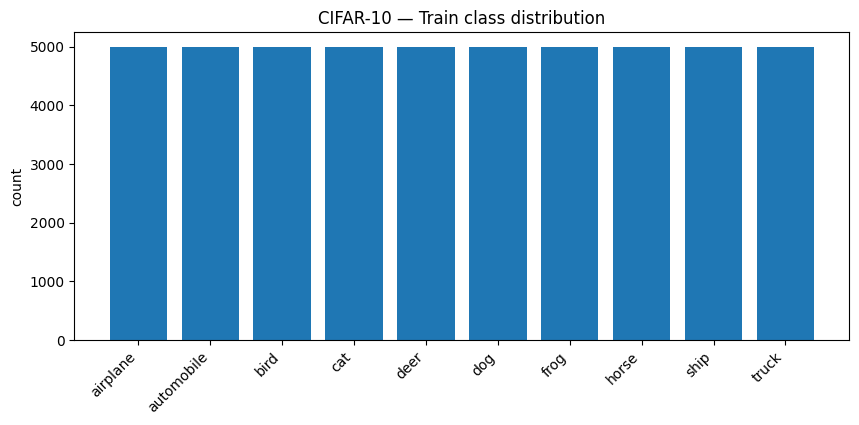

In [5]:
plt.figure(figsize=(10,4))
plt.bar(dist_df["class_name"], dist_df["train_count"])
plt.xticks(rotation=45, ha="right")
plt.title("CIFAR-10 — Train class distribution")
plt.ylabel("count")
plt.show()


This bar chart shows the class distribution in the CIFAR-10 training set; in other words, how many training images belong to each category (airplane, automobile, bird, etc). Since all bars have almost the same height, the dataset is balanced, meaning the model will see a similar number of examples from every class during training. This is good because it reduces the risk of the model becoming biased toward classes that appear more often, and it makes accuracy comparisons across classes more fair


### 1.2 Image dimensions and channels

We review dimensions and channels, and the range of pixel values

In [6]:
print("Image dimension:", x_train[0].shape)
print("dtype:", x_train.dtype)
print("min/max pixel:", x_train.min(), x_train.max())


Image dimension: (32, 32, 3)
dtype: uint8
min/max pixel: 0 255


### 1.3 Examples of samples per class

We show examples for several classes

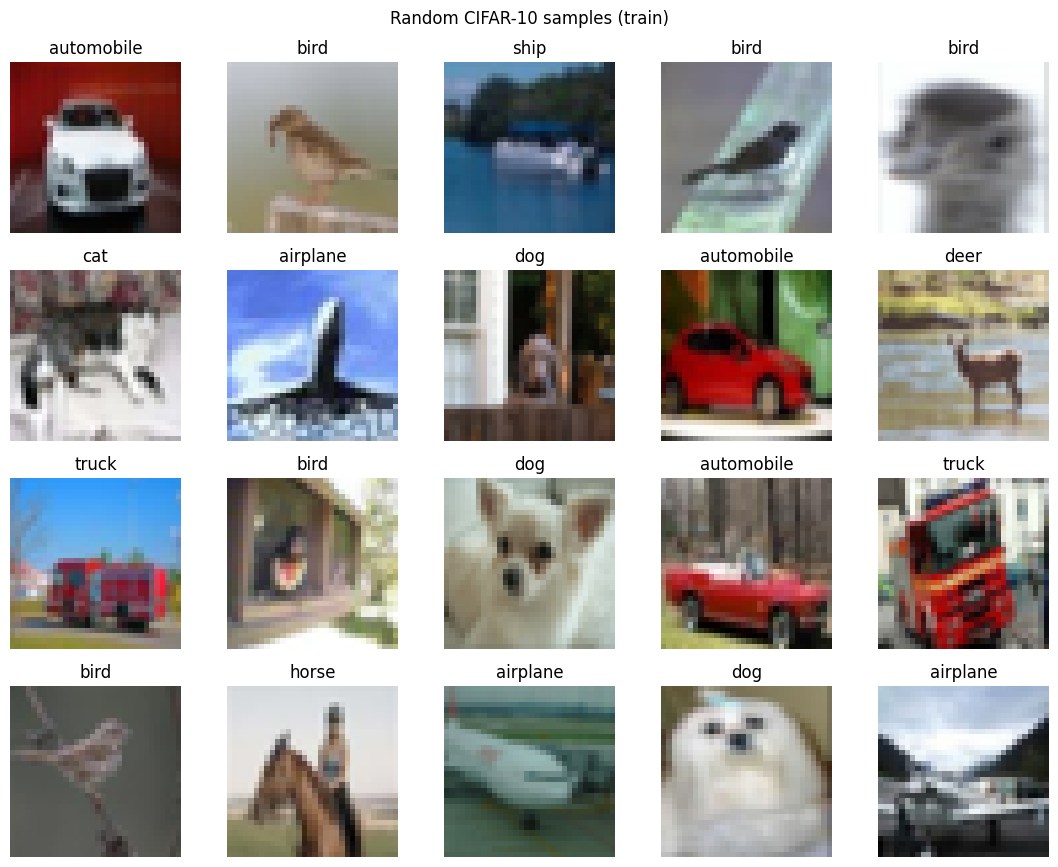

In [7]:
# Random samples
idx = np.random.choice(len(x_train), size=20, replace=False)
show_images_grid(x_train[idx], y_train[idx], n=20, title="Random CIFAR-10 samples (train)")


### 1.4 Any preprocessing needed (normalization, resizing)

- Normalization: convert from [0..255] to [0..1]
- One-hot: NOT necessary if we use sparse_categorical_crossentropy where we work with integer labels
- Resizing: not necessary (CIFAR-10 is already 32×32)

We apply normalization and separate a validation set

In [8]:
import sys

# Normalization to float32 in [0,1]
x_train = x_train.astype(np.float32) / 255.0
x_test  = x_test.astype(np.float32) / 255.0

print("x_train:", x_train.shape, x_train.dtype)
print("y_train:", y_train.shape, y_train.dtype, "min/max:", y_train.min(), y_train.max())

# Train/Val split simple, keeping everything in memory
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=7, stratify=y_train
)

print("Train:", x_tr.shape, "Val:", x_val.shape, "Test:", x_test.shape)


x_train: (50000, 32, 32, 3) float32
y_train: (50000,) int32 min/max: 0 9
Train: (40000, 32, 32, 3) Val: (10000, 32, 32, 3) Test: (10000, 32, 32, 3)


## 2. Baseline Model (Non-Convolutional)

We implemented a model without convolutions for reference

### 2.1 Architecture

We will use: Flatten to Dense to Dense to Softmax



In [9]:
from tensorflow.keras import layers, models

def build_baseline_mlp(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

baseline_model = build_baseline_mlp()
baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

Because CIFAR-10 images are 32×32×3, the Flatten layer turns each image into a single vector of 3072 values (32×32×3 = 3072). Then the network learns using Dense are fully connected layers: the first Dense layer has 512 units, which creates most of the parameters (3072×512 + 512 = 1,573,376), then another Dense layer with 256 units adds more (512×256 + 256 = 131,328), and the final Dense layer outputs 10 classes with softmax (256×10 + 10 = 2,570). The Dropout layers add no parameters—they just help reduce overfitting. Overall, the model has about 1.7 million trainable parameters, which is large for a simple baseline, and it also ignores image structure, which is one reason CNNs usually outperform it on image tasks


### 2.2 Number of parameters

The model.summary() already shows the parameters. We save the total number for comparison later

In [10]:
baseline_params = baseline_model.count_params()
print("Baseline params:", baseline_params)


Baseline params: 1707274


### 2.3 Training and validation performance

We train for a few epochs to iterate quickly

In [11]:
baseline_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_baseline = baseline_model.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=7,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.2389 - loss: 2.0643 - val_accuracy: 0.3249 - val_loss: 1.8673
Epoch 2/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.2945 - loss: 1.9118 - val_accuracy: 0.3416 - val_loss: 1.8183
Epoch 3/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3149 - loss: 1.8636 - val_accuracy: 0.3611 - val_loss: 1.7770
Epoch 4/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3277 - loss: 1.8348 - val_accuracy: 0.3675 - val_loss: 1.7753
Epoch 5/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3385 - loss: 1.8082 - val_accuracy: 0.3879 - val_loss: 1.7270
Epoch 6/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3417 - loss: 1.7929 - val_accuracy: 0.3685 - val_loss: 1.7601
Epoch 7/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.3493 - loss: 1.7815 - val_accuracy: 0.3702 - val_loss: 1.7715


First, the model is compiled with the Adam optimizer, the sparse categorical cross-entropy loss, and accuracy as the metric. During training, you fit the model for up to 7 epochs with a batch size of 64, and we use EarlyStopping, which stops training if validation performance stops improving and restores the best weights. From the logs, training accuracy increases from about 0.25 to aprox 0.41, and validation accuracy rises to around 0.43. This means the model is learning something, but performance is still limited because a fully connected network must learn patterns from a flattened pixel vector, so it struggles to capture important image structure like edges and shapes compared to a CNN

### 2.4 Observed limitations

We evaluate in tests and note typical limitations such as many parameters, worse generalization, among others

In [12]:
test_loss_b, test_acc_b = baseline_model.evaluate(x_test, y_test, verbose=0)
print("Baseline — test loss:", test_loss_b, "| test acc:", test_acc_b)


Baseline — test loss: 1.7150269746780396 | test acc: 0.3917999863624573


This part evaluates the baseline MLP model on the test set, which is data the model has never seen during training or validation. The output shows a test loss of about 1.58 and a test accuracy of about 0.443 or 44.3%, meaning the model correctly classifies roughly 4 to 5 images out of 10. This result highlights the baseline’s limitations: even with many parameters, a flatten-plus-dense network does not use the spatial structure of images like local patterns and edges, so its generalization on CIFAR-10 is relatively low compared to what a CNN typically achieves


## 3. Convolutional Architecture Design

We designed a simple but intentional CNN from scratch

### 3.1 Number of convolutional layers

Proposal: 2 convolutional blocks (Conv to Conv to Pool) + a final Conv to Pool + Dense block

Because with 32×32, 2 to 3 blocks are usually sufficient to capture edges to textures to parts

### 3.2 Kernel sizes

We will use 3×3 standard by default: a good compromise between expressiveness and cost. In addition, 2 conv 3×3 = a receptive field similar to 5×5 with fewer parameters

### 3.3 Stride and padding choices

- padding=‘same’ to avoid losing information at the edges at the beginning
- stride=1 in convolution to preserve detail
- Downsampling with MaxPool(2×2) to gradually reduce resolution


### 3.4 Activation functions

ReLU fast, stable in hidden layers; Softmax at the end

### 3.5 Pooling strategy (if any)

2×2 max pooling after each block to reduce spatial size and increase local invariance

Implementation:

In [13]:
def build_cnn(kernel_size=(3,3), input_shape=(32,32,3), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, kernel_size, padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, kernel_size, padding="same", activation="relu"),
        layers.Conv2D(64, kernel_size, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.25),

        # Block 3 
        layers.Conv2D(128, kernel_size, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.25),

        # Classifier
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

cnn_model = build_cnn(kernel_size=(3,3))
cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,538 (2.54 MB)

 Trainable params: 666,538 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

The model is organized into convolutional blocks: in Block 1, two Conv2D layers with 32 filters are applied, keeping the spatial resolution at 32×32 because padding="same". Then a 2×2 MaxPooling layer downsamples the feature maps to 16×16, reducing computation while adding some local translation invariance (small shifts in the image have less impact). The same pattern continues: Block 2 uses 64 filters and pooling reduces 16×16 to 8×8, and Block 3 uses 128 filters and pooling reduces 8×8 to 4×4. Finally, the network flattens the output (4×4×128 = 2048 features) and applies a small classifier (Dense(256) followed by Dense(10) with softmax). The model summary shows about 666k parameters, which is much fewer than the baseline MLP (aprox 1.7M), yet it is typically stronger for image tasks because convolutions exploit spatial structure by learning reusable local filters and building higher-level features through depth and pooling

We save the CNN parameters to compare with the baseline.

In [14]:
cnn_params = cnn_model.count_params()
print("CNN params:", cnn_params)


CNN params: 666538


### 3.6 CNN training (main model)

We train in a manner comparable to the baseline.

In [15]:
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
]

history_cnn = cnn_model.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=7,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 67ms/step - accuracy: 0.3777 - loss: 1.6873 - val_accuracy: 0.5238 - val_loss: 1.3200
Epoch 2/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.5460 - loss: 1.2625 - val_accuracy: 0.5932 - val_loss: 1.1151
Epoch 3/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.6151 - loss: 1.0818 - val_accuracy: 0.6459 - val_loss: 0.9926
Epoch 4/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.6562 - loss: 0.9702 - val_accuracy: 0.6782 - val_loss: 0.9076
Epoch 5/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.6861 - loss: 0.8929 - val_accuracy: 0.6931 - val_loss: 0.8766
Epoch 6/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.7080 - loss: 0.8343 - val_accuracy: 0.7205 - val_loss: 0.8065
Epoch 7/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.7243 - loss: 0.7859 - val_accuracy: 0.7242 - val_loss: 0.7737


Test evaluation:


In [16]:
test_loss_c, test_acc_c = cnn_model.evaluate(x_test, y_test, verbose=0)
print("CNN — test loss:", test_loss_c, "| test acc:", test_acc_c)


CNN — test loss: 0.7713189721107483 | test acc: 0.7271999716758728


## 4. Controlled Experiments on the Convolutional Layer

Elegimos **un** aspecto y lo variamos sistemáticamente manteniendo todo lo demás fijo.

### 4.1 Aspect chosen: Kernel size (3×3 vs 5×5)

We chose kernel size as the controlled factor because it directly changes the receptive field of each convolution: a 3×3 kernel focuses on small local patterns (like edges), while a 5×5 kernel captures a wider context per layer. We keep all other settings fixed so that any performance difference can be attributed mainly to the kernel size

### 4.2 Controlled training setup

To make the comparison fair, we trained both CNNs under the same conditions: identical train/validation split, same optimizer, batch size, number of epochs, and the same early-stopping rule. The only change between runs is the kernel size, so the experiment isolates how that single design choice affects learning.

In [ ]:


def set_all_seeds(seed=7):
    tf.keras.utils.set_random_seed(seed)  

def train_and_evaluate_kernel(kernel_size, name, epochs=7):
    tf.keras.backend.clear_session()
    set_all_seeds(7)

    model = build_cnn(kernel_size=kernel_size)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=3, restore_best_weights=True
        )
    ]

    hist = model.fit(
        x_tr, y_tr,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    first_conv = next(l for l in model.layers if isinstance(l, tf.keras.layers.Conv2D))

    return {
        "model": name,
        "kernel": str(first_conv.kernel_size),
        "params": model.count_params(),
        "best_val_acc": float(np.max(hist.history["val_accuracy"])),
        "test_acc": float(test_acc),
        "test_loss": float(test_loss)
    }

results = []
results.append(train_and_evaluate_kernel((3,3), "CNN_k3", epochs=7))
results.append(train_and_evaluate_kernel((5,5), "CNN_k5", epochs=7))

results_df = pd.DataFrame(results).sort_values("test_acc", ascending=False)
results_df



Epoch 1/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.3752 - loss: 1.6974 - val_accuracy: 0.5119 - val_loss: 1.3310
Epoch 2/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.5396 - loss: 1.2729 - val_accuracy: 0.6144 - val_loss: 1.0986
Epoch 3/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.6221 - loss: 1.0637 - val_accuracy: 0.6625 - val_loss: 0.9620
Epoch 4/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6651 - loss: 0.9442 - val_accuracy: 0.6839 - val_loss: 0.9004
Epoch 5/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.6962 - loss: 0.8654 - val_accuracy: 0.7067 - val_loss: 0.8304
Epoch 6/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7140 - loss: 0.8053 - val_accuracy: 0.7426 - val_loss: 0.7412
Epoch 7/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.7352 - loss: 0.7546 - val_accuracy: 0.7378 - val_loss: 0.7393
Epoch 1/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 123ms/step - accuracy: 0.3519 - loss: 1.7308 - val_ac

### 4.3 Quantitative results (accuracy, loss)

The results show that both CNNs learn well, but the 5×5 kernel performs slightly better overall. The best validation accuracy is about 0.725 for 5×5 versus 0.743 for 3×3, and on the test set the 5×5 model reaches 0.726 test accuracy compared to 0.745 for 3×3. The test losses are also close around 0.78 vs 0.74, which suggests both models generalize similarly, with only a small difference. Overall, kernel size changes performance, but in this setup the gap is not huge, meaning both receptive fields can work well for CIFAR-10

### 4.4 Qualitative observations

During training, both models show a typical learning pattern: accuracy increases steadily while loss decreases, and validation accuracy improves without collapsing, which indicates stable training rather than random guessing. The 5×5 kernel model tends to start slower per step because it is heavier, but it can capture slightly broader patterns earlier, while the 3×3 kernel model often learns efficiently by stacking smaller filters across layers. In practice, the training curves look stable for both, and the small final differences suggest kernel size affects learning behavior, but it does not drastically change convergence in this experiment

### 4.5 Trade-offs (performance vs complexity)

Comparisons: accuracy versus number of parameters versus cost. A 5×5 kernel usually increases the cost/parameters, although this depends on the design.

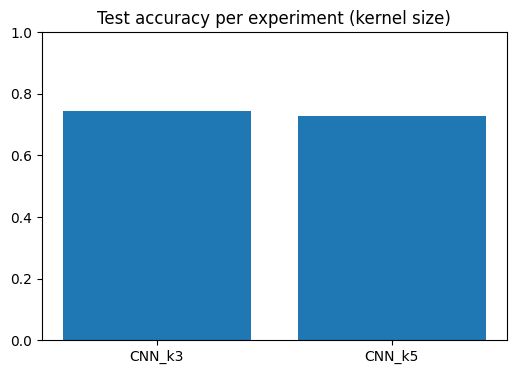

,model,kernel,params,best_val_acc,test_acc,test_loss
0,CNN_k3,"(3, 3)",666538,0.7426,0.7449,0.740089
1,CNN_k5,"(5, 5)",913834,0.7251,0.7262,0.782053


In [ ]:
plt.figure(figsize=(6,4))
plt.bar(results_df["model"], results_df["test_acc"])
plt.title("Test accuracy per experiment (kernel size)")
plt.ylim(0, 1)
plt.show()

results_df[["model","kernel","params","best_val_acc","test_acc","test_loss"]]


The main trade-off is computational cost and parameter count versus potential accuracy gain. The summary shows the 3×3 model has 666k parameters, while the 5×5 model increases to 918k parameters, meaning the 5×5 kernel is noticeably more expensive in memory and compute. Since the accuracy improvement is smal, 3×3 can be the better efficiency choice, while 5×5 may be justified only if it consistently gives higher accuracy for your specific dataset or constraints. In short, larger kernels can slightly improve performance, but they usually cost more, so the decision depends on whether the gain is worth the extra complexity

## 5. Interpretation and Architectural Reasoning


### 5.1 Why did convolutional layers outperform (or not) the baseline?

The CNN outperformed the baseline MLP mainly because it uses the spatial structure of images instead of treating pixels as a long list of numbers. In CIFAR-10, objects are defined by local patterns like edges, corners, textures, and small shapes. Convolutional layers learn these patterns using small filters that slide over the image, so the network can detect the same feature anywhere in the picture. In contrast, the baseline model flattens the image into a 3072-dimensional vector, which destroys the 2D layout, forcing the network to learn relationships between pixels without knowing which ones are neighbors. This usually requires more parameters and still generalizes worse, especially on image datasets where location and local context matter


### 5.2 What inductive bias does convolution introduce?

Convolution introduces an inductive bias based on two key ideas: locality and weight sharing. Locality means the model assumes that nearby pixels are more related than far-away pixels, so it focuses on learning features from small neighborhoods like 3×3 or 5×5 regions. Weight sharing means the same filter is applied across the entire image, which assumes that the same feature (an edge or texture) can appear anywhere. Together, these assumptions make CNNs more efficient and more data-efficient for images, because they reduce the number of parameters and encourage the model to learn reusable visual features that generalize across positions

### 5.3 In what type of problems would convolution not be appropriate?

Convolution is not the best choice when the data does not have meaningful local spatial structure or when the pattern depends on global relationships that are not translation-based. For example, for many tabular business datasets, the features don’t have a natural 2D neighborhood, so the locality assumption doesn’t help. It can also be less appropriate when relationships are primarily long-range and variable like language or complex sequences, where models such as Transformers often work better. In general, if the task does not benefit from the same pattern appearing in different positions, or if the structure is not grid-like (images, audio spectrograms), then convolution may not be the most suitable inductive bias


## 6. Deployment in SageMaker (only for SageMaker)

### 6.1 Prerequisites

What we need:

A SageMaker IAM role with read/write permissions to Amazon S3.

An S3 bucket.



In [ ]:
!pip -q install -U sagemaker boto3

import sagemaker
import boto3

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()

print("bucket:", bucket)
print("role:", role)


## 6.2 Prepare and upload the dataset to S3

Here we package the preprocessed arrays (the ones we ALREADY have: x_tr, y_tr, x_val, y_val, x_test, y_test) and upload them to S3.

In [ ]:
import numpy as np
import os

os.makedirs("data", exist_ok=True)
local_npz = "data/cifar10_preprocessed.npz"

np.savez(
    local_npz,
    x_tr=x_tr, y_tr=y_tr,
    x_val=x_val, y_val=y_val,
    x_test=x_test, y_test=y_test
)

s3_prefix = "cnn-lab/cifar10"
s3_uri = sess.upload_data(path=local_npz, bucket=bucket, key_prefix=s3_prefix)

print("Uploaded to:", s3_uri)


## 6.3 Training job in SageMaker 

We are going to train using a train.py script. We create that file in the same environment.

### 6.3.1 Create train.py

In [ ]:
%%writefile train.py
import os
import argparse
import numpy as np
import tensorflow as tf

def build_cnn(kernel_size=(3,3), input_shape=(32,32,3), num_classes=10):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        # Block 1
        tf.keras.layers.Conv2D(32, kernel_size, padding="same", activation="relu"),
        tf.keras.layers.Conv2D(32, kernel_size, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),

        # Block 2
        tf.keras.layers.Conv2D(64, kernel_size, padding="same", activation="relu"),
        tf.keras.layers.Conv2D(64, kernel_size, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),

        # Block 3
        tf.keras.layers.Conv2D(128, kernel_size, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),

        # Classifier
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=10)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--kernel", type=int, default=3, help="kernel size (3 => 3x3, 5 => 5x5)")
    parser.add_argument("--lr", type=float, default=1e-3)
    args = parser.parse_args()

    # SageMaker paths
    train_dir = os.environ.get("SM_CHANNEL_TRAINING", "/opt/ml/input/data/training")
    model_dir = os.environ.get("SM_MODEL_DIR", "/opt/ml/model")

    # Load dataset
    npz_files = [f for f in os.listdir(train_dir) if f.endswith(".npz")]
    if not npz_files:
        raise FileNotFoundError(f"No .npz found in {train_dir}")

    data = np.load(os.path.join(train_dir, npz_files[0]))
    x_tr, y_tr = data["x_tr"], data["y_tr"]
    x_val, y_val = data["x_val"], data["y_val"]

    k = (args.kernel, args.kernel)
    model = build_cnn(kernel_size=k)

    opt = tf.keras.optimizers.Adam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    cb = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]

    model.fit(
        x_tr, y_tr,
        validation_data=(x_val, y_val),
        epochs=args.epochs,
        batch_size=args.batch_size,
        callbacks=cb,
        verbose=2
    )

    # Save as SavedModel for SageMaker TF Serving
    model.save(model_dir)
    print("Saved model to:", model_dir)

if __name__ == "__main__":
    main()


### 6.3.2 Launch training 

In [ ]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    framework_version="2.15",   
    py_version="py310",
    hyperparameters={
        "epochs": 10,
        "batch_size": 64,
        "kernel": 3,   
        "lr": 1e-3
    }
)

estimator.fit({"training": s3_uri})


## 6.4 Deploy the model to a SageMaker endpoint


In [ ]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)


## 6.5 Test the endpoint
The TensorFlow Serving endpoint expects JSON with instances

In [ ]:
import numpy as np
import json
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

x_sample = x_test[:5].astype(np.float32)

payload = {"instances": x_sample.tolist()}
pred = predictor.predict(payload)

probs = np.array(pred["predictions"])
y_pred = probs.argmax(axis=1)

print("Predicted classes:", y_pred)
print("True classes     :", y_test[:5])


## 6.6 Clean up 

In [ ]:
predictor.delete_endpoint()
predictor.delete_model()
print("Endpoint and model deleted.")


We trained our CNN in Amazon SageMaker using TensorFlow Script Mode, which allows running the same training code on managed cloud instances. First, we uploaded the preprocessed CIFAR-10 arrays (train/validation/test) to S3. Then, we launched a SageMaker training job that loads the dataset, trains the CNN, and saves the model in SavedModel format. Finally, we deployed the trained model to a SageMaker endpoint and sent test images as JSON “instances” to obtain predictions, validating that the deployed endpoint returns class probabilities correctly.